In [1]:
using Printf
using Plots

using PanelMethod
using .Airfoils: Xform, mirror, chordline, leading_edge, trailing_edge

In [2]:
# | Choose an airfoil defined by https://en.wikipedia.org/wiki/Joukowsky_transform
airfoil = Airfoils.JoukowskyAirfoil(0.1, 0.1);

# | Choose an airfoil by name from airfoiltools.com
# airfoil = AirfoilTools.get_airfoil("n22-il");

# | Choose a random airfoil from airfoiltools.com
# name = rand(AirfoilTools.airfoil_names()); @show name
# airfoil = AirfoilTools.get_airfoil(name);

Xform(af) = Xform{Float64}(0.0 + 0.0im, 1.0 + 0.0im)


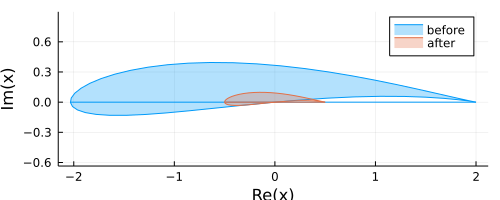

In [3]:
center = 0 + 0im # center of the chord line
scale = 1 + 0im  # difference from leading to trailing edge
af = airfoil |> Xform(center, scale)  # transform the airfoil

# additionally, the airfoil can be mirrored across the chord line
# af = airfoil |> Xform(center, scale) |> mirror

# Retrieve the equivalent `Xform` of any `airfoil` with `Xform(airfoil)`
@show Xform(af)

plt = plot(aspect_ratio=:equal, size=(500, 200))
for (a, name, color) in ((airfoil, "before", 1), (af, "after", 2))
    z = Airfoils.position.(Ref(a), LinRange(0, 1, 50))
    plot!(z; color, label=name, fill=true, fc=:match, fa=0.3)  # parameterization
    plot!([leading_edge(a), trailing_edge(a)]; color, label=false)  # chord line
end
plt

In [4]:
sheet = Sheet(af, 200);  # create a vortex sheet from airfoil `af` with 200 panels

In [5]:
flow = let v = 1, α = deg2rad(10)  # freestream velocity and angle of attack

    # | The flow can be directly created from `sheet`
    Flow(sheet, af, v, α)

    # | The call above really expands to something like this (N = panel count):
    # group = SheetGroup(sheet)                 # O(N^2) allocation
    # gammas = VortexStrengths(group)           # O(N) allocation
    # Flow(group, af, gammas, 1, deg2rad(10));  # O(1) allocation

    # In a long loop, it is beneficial to do as many allocations before-hand as possible.
    # The `Sheets.update!` function can mutate a `Sheet` or `SheetGroup` to avoid
    # allocations if the sheet geometry is changed.
end;

In [6]:
println("U∞ =  ", round(Flows.freestream(flow), sigdigits=4))
@printf " v = % .6g\n" flow |> Flows.freestream |> abs
@printf " α = % .6g°\n" flow |> Flows.angle_of_attack |> rad2deg
@printf "CL = % .6g\n" flow |> Flows.lift_coeff
@printf "CM = % .6g (about c/4)\n" Flows.moment_coeff(flow, chordline(af, 1/4))

U∞ =  0.9848 + 0.1736im
 v =  1
 α =  10°
CL =  1.7911
CM = -0.148193 (about c/4)


In [7]:
@printf "aerodynamic center | %.3fc\n" Sheets.aerodynamic_center(flow)
@printf "center of pressure | %.3fc\n" Flows.center_of_pressure(flow)

aerodynamic center | 0.258c
center of pressure | 0.333c


In [8]:
let z = 1 + 2im
    println('\n' * "-" ^ write(stdout, "z = $z"))
    println("velocity at z : ", round(Flows.velocity(flow, z), sigdigits=6))
    println("     C_p at z : ", round(Flows.pressure_coeff(flow, z), sigdigits=6))
end

z = 1 + 2im
-----------
velocity at z : 1.03916 + 0.140466im
     C_p at z : -0.0995817


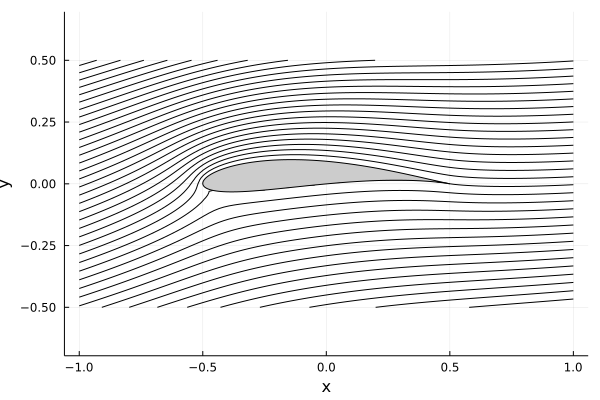

In [9]:
# Choose a grid of points to evaluate the streamfunction at
x = LinRange(-1, 1, 100)
y = LinRange(-0.5, 0.5, 100)

ψ = Flows.streamfunction.(Ref(flow), complex.(permutedims(x), y))  # streamfunction grid
ψ1, ψ2 = extrema(ψ)
ψ_stag = Flows.streamfunction(flow, chordline(af, 1 + 1e-5))  # stagnation point

nlevels = 40
# set the contour levels so that a contour aligns with the stagnation point
levels = range(ψ1, ψ2, step=(ψ_stag-ψ1)/round(nlevels*(ψ_stag-ψ1)/(ψ2-ψ1)))

contour(x, y, ψ, levels=levels, aspect_ratio=:equal, line=:black, colorbar=false)

plot!(sheet.endpoints, line=:black, legend=false, fill=true,
      fc=Colors.RGB(0.8), xlabel=:x, ylabel=:y)

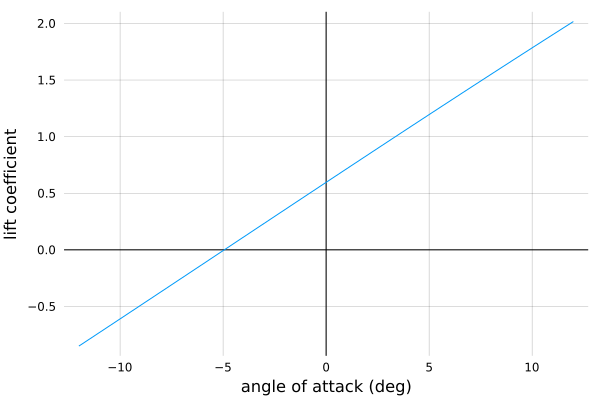

In [10]:
# Generating a lift coefficient vs angle of attack plot:

function lift_coeffs(airfoil::Airfoils.Airfoil, α_range::AbstractVector{<:Real})
    CL = similar(α_range)
    # Since the angle of attack is being looped over, pre-allocate the sheet group
    # and vortex strengths.
    group = SheetGroup(Sheet(airfoil, 150))
    γ = VortexStrengths(group)
    map(α_range) do α
        flow = Flow(group, airfoil, γ, 1, α)
        Flows.lift_coeff(flow)
    end
end

let 
    α_deg = LinRange(-12, 12, 50)
    α_rad = LinRange(deg2rad.(extrema(α_deg))..., length(α_deg))
    CL = lift_coeffs(af, α_rad)

    plot(α_deg, CL, xlabel="angle of attack (deg)", ylabel="lift coefficient", legend=false,
         frame=:zerolines, gridalpha=0.3)
end

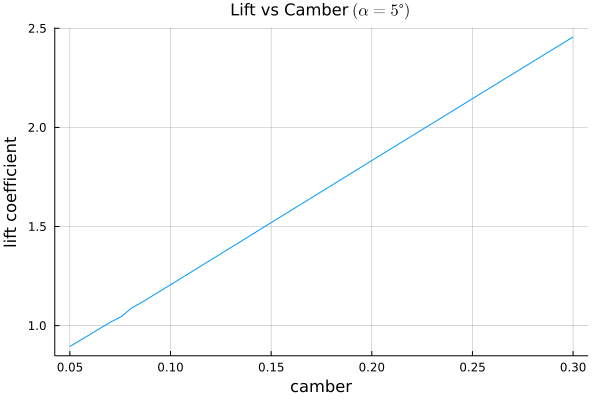

In [11]:
function lift_coeffs(camber_range::AbstractVector{<:Real}, thickness; α=deg2rad(5))
    sheet = Sheet{Float64}(250)  # create an uninitialized sheet with 250 panels
    group = SheetGroup(sheet, undef)  # create a sheetgroup and don't initialize (undef)
    γ = VortexStrengths(group)  # uninitialized vortex strengths

    map(camber_range) do camber
        airfoil = Airfoils.JoukowskyAirfoil(thickness, camber)
        Sheets.update!(sheet, airfoil)  # update the sheet geoemtry with `airfoil`
        Sheets.update!(group)  # re-solve the linear system
        Flow(group, airfoil, γ, 1, α) |> Flows.lift_coeff
    end
end

let camber_range = LinRange(0.05, 0.3, 50), thickness = 0.1, α_deg = 5
    CL = lift_coeffs(camber_range, thickness; α=deg2rad(α_deg))
    
    plot(camber_range, CL; xlabel="camber", ylabel="lift coefficient", legend=false,
         title="Lift vs Camber \$(\\alpha=$α_deg\\degree)\$", titlefont=11,
         gridalpha=0.3)
end

In [12]:
airfoils = [f(af) for f in (Xform(0.3im, 1), Xform(-0.4im, 1))]

sheets = Sheet.(airfoils, 150)

multiflow = let v = 1, α = deg2rad(6)
    chord = first(airfoils)  # use the first airfoil's chord for nondimensionalizing
    Flow(sheets, chord, v, α)  # create a flow with multiple sheets
end;

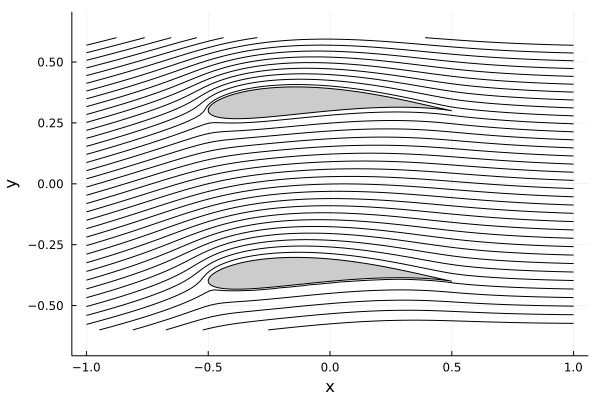

In [13]:
x = LinRange(-1, 1, 100)
y = LinRange(-0.6, 0.6, 100)
contour(x, y, (x, y) -> Flows.streamfunction(multiflow, complex(x, y)),
        levels=40, aspect_ratio=:equal, line=:black, colorbar=false)

for sheet in sheets
      plot!(sheet.endpoints, line=:black, legend=false, fill=true,
            fc=Colors.RGB(0.8), xlabel=:x, ylabel=:y)
end
plot!()